In [1]:
import os
import re
from collections import Counter
import json
import datetime
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cm = 1/2.54

# force GPU device
os.environ["CUDA_VISIBLE_DEVICES"]='1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout, Bidirectional, Embedding, Input, RepeatVector, TimeDistributed, Reshape
from keras import Sequential, Model
from keras.losses import CategoricalCrossentropy, CategoricalFocalCrossentropy, SparseCategoricalCrossentropy
from keras.optimizers import Adam
from keras.models import load_model
from keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from utils import *

seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

In [2]:
data_directory = '/home/jrosendahl/datasets/cadets/sequences_export_benign_filetypes_path_ts/'
experiment_name = 'path_autoencoder'

checkpoint_path = f'saves/{experiment_name}'
model_path = f'{checkpoint_path}/model.keras'
log_path = f'{checkpoint_path}/log.csv'
history_path = f'{checkpoint_path}/history.npy'

# ensure directory exists
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

In [3]:
# list of limitations for paths:
# allowed charaters: alphanumeric chars + '/.'
# all chars are transformed to lowercase
def preprocess_path(path: str) -> str:
    path = path.lower()
    path = re.sub(r'[^a-z0-9/._]', '', path)
    return path

In [4]:
# load data

vocab = set()
X = []
longest_path = 0
files_loaded = 0

for filename in os.listdir(data_directory):
    with open(os.path.join(data_directory, filename), 'r') as f:
        files_loaded += 1
        if files_loaded % 50000 == 0:
            print(f"Files loaded: {files_loaded}")

        for line in f:
            line = line.split(',')
            path1 = line[4]
            path2 = line[5]


            for path in [path1, path2]:
                if path in ['', 'None']:
                    continue
                path = preprocess_path(path1)
                vocab.update(path)
                X.append(path)


mean_length = np.mean([len(path) for path in X])
vocab_size = len(vocab)


print(f"Files loaded: {files_loaded}")
print(f'{len(X)=}')
print(f'{vocab_size=}')
print(f'{longest_path=}')
print(f'{mean_length=}')

Files loaded: 50000


Files loaded: 100000


Files loaded: 150000


Files loaded: 200000


Files loaded: 215150
len(X)=8161337
vocab_size=39
longest_path=0
mean_length=16.37407400282576


In [5]:
# sort vocab, build maps and save
vocab = sorted(vocab)
vocab = [''] + vocab

# save vocab
with open(f'{checkpoint_path}/vocab.json', 'w') as f:
    json.dump(vocab, f)

# build char to idx and idx to char maps
char_to_idx = {char: idx for idx, char in enumerate(vocab)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}


print(f'{char_to_idx=}')
print(f'{idx_to_char=}')

# save to disk
with open(f'{checkpoint_path}/char_to_idx.json', 'w') as f:
    json.dump(char_to_idx, f)

with open(f'{checkpoint_path}/idx_to_char.json', 'w') as f:
    json.dump(idx_to_char, f)

char_to_idx={'': 0, '.': 1, '/': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '_': 13, 'a': 14, 'b': 15, 'c': 16, 'd': 17, 'e': 18, 'f': 19, 'g': 20, 'h': 21, 'i': 22, 'j': 23, 'k': 24, 'l': 25, 'm': 26, 'n': 27, 'o': 28, 'p': 29, 'q': 30, 'r': 31, 's': 32, 't': 33, 'u': 34, 'v': 35, 'w': 36, 'x': 37, 'y': 38, 'z': 39}
idx_to_char={0: '', 1: '.', 2: '/', 3: '0', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: '9', 13: '_', 14: 'a', 15: 'b', 16: 'c', 17: 'd', 18: 'e', 19: 'f', 20: 'g', 21: 'h', 22: 'i', 23: 'j', 24: 'k', 25: 'l', 26: 'm', 27: 'n', 28: 'o', 29: 'p', 30: 'q', 31: 'r', 32: 's', 33: 't', 34: 'u', 35: 'v', 36: 'w', 37: 'x', 38: 'y', 39: 'z'}


In [6]:
# load vocab and maps from disk

with open(f'{checkpoint_path}/vocab.json', 'r') as f:
    vocab_loaded = json.load(f)

with open(f'{checkpoint_path}/char_to_idx.json', 'r') as f:
    char_to_idx_loaded = json.load(f)

with open(f'{checkpoint_path}/idx_to_char.json', 'r') as f:
    idx_to_char_loaded = json.load(f)
    idx_to_char_loaded = {int(k): v for k, v in idx_to_char_loaded.items()}


# assert that loaded vocab and maps are the same as the ones used
if not vocab_loaded == vocab:
    print('Loaded vocab is not the same as the one used')
    print(f'{vocab_loaded=}')
    print(f'{vocab=}')

if not char_to_idx_loaded == char_to_idx:
    print('Loaded char_to_idx is not the same as the one used')
    print(f'{char_to_idx_loaded=}')
    print(f'{char_to_idx=}')

if not idx_to_char_loaded == idx_to_char:
    print('Loaded idx_to_char is not the same as the one used')
    print(f'{idx_to_char_loaded=}')
    print(f'         {idx_to_char=}')

In [7]:
fixed_length = 50

def vectorize_data(X, char_to_idx, fixed_length):
    X_vec = np.zeros((len(X), fixed_length), dtype=np.int32)
    for i, path in enumerate(X):
        for j, char in enumerate(path):
            if j >= fixed_length:
                break
            X_vec[i, j] = char_to_idx[char]
    return X_vec

def vectorized_to_string(X, idx_to_char):
    return [''.join([idx_to_char[idx] for idx in path]) for path in X]

X_vec = vectorize_data(X, char_to_idx, fixed_length)

In [8]:
def output_to_string(output: np.ndarray, idx_to_char: dict) -> str:
    output_argmax = np.argmax(output, axis=-1)
    return vectorized_to_string(output_argmax, idx_to_char)

In [9]:
print(f'{X_vec.shape=}')
print(f'{X_vec[0]=}')

X_vec.shape=(8161337, 50)
X_vec[0]=array([ 2, 34, 32, 31,  2, 15, 22, 27,  2, 33, 28, 29,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)


In [10]:
class DataGenerator(Sequence):
    def __init__(self, data, batch_size, fixed_length, vocab_size, shuffle=True):
        # call super
        super(DataGenerator, self).__init__()
        self.data = data
        self.batch_size = batch_size
        self.fixed_length = fixed_length
        self.vocab_size = vocab_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        # Generate indices for the batch
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data for the batch
        X_batch = self.__data_generation(batch_indices)

        # Since it's an autoencoder, the target data is the same as the input data
        return X_batch, X_batch

    def on_epoch_end(self):
        # Shuffle indices after each epoch if shuffle is True
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_indices):
        # Generate data for a batch of given indices
        # This is where you can customize your data loading and processing
        batch_data = [self.data[i] for i in batch_indices]

        # Convert the batch data to a numpy array (or whatever format is needed)
        X_batch = np.array(batch_data)

        # Ensure the data is padded or truncated to fixed_length
        X_batch = np.array([np.pad(x, (0, max(0, self.fixed_length - len(x))), constant_values=0)[:self.fixed_length] for x in X_batch])

        return X_batch

In [11]:
# prep data generators
batch_size = 512
train_size = int(0.8 * len(X_vec))
val_size = int(0.15 * len(X_vec))
test_size = len(X_vec) - train_size - val_size

train_gen = DataGenerator(X_vec[:train_size], batch_size, fixed_length, vocab_size)
val_gen = DataGenerator(X_vec[train_size:train_size+val_size], batch_size, fixed_length, vocab_size)
test_gen = DataGenerator(X_vec[train_size+val_size:], batch_size, fixed_length, vocab_size)

x_gen = DataGenerator(X_vec, batch_size, fixed_length, vocab_size)

In [12]:
# debug print first 5 entries in each set

for i in range(5):
    print(f'{vectorized_to_string(train_gen[i][0], idx_to_char)}')
print()

for i in range(5):
    print(f'{vectorized_to_string(val_gen[i][0], idx_to_char)}')
print()

for i in range(5):
    print(f'{vectorized_to_string(test_gen[i][0], idx_to_char)}')
print()

# first 5 in full dataset
for i in range(5):
    print(f'{vectorized_to_string(x_gen[i][0], idx_to_char)}')

['/dev/kmem', '/dev/kmem', '/dev/kmem', '/dev/random', 'unknown', '/etc/services', '/dev/random', '/usr/lib/libypclnt.so.4', 'unknown', '/dev/kmem', 'unknown', '/dev/kmem', '/bin/sleep', '/etc/pwd.db', '/usr/share/zoneinfo/utc', '/var/run/ldelf.so.hints', '/usr/share/zoneinfo/utc', '/etc/pwd.db', '/etc/pwd.db', '/var/run/ldelf.so.hints', 'unknown', 'unknown', 'unknown', '/usr/local/sbin/lsof', '/dev/kmem', '/dev/random', '/etc/pwd.db', '/usr/local/share/doc/ruby24/maintainers.rdoc', '/etc/libmap.conf', '/dev/kmem', '/etc/nsswitch.conf', '/etc/services', '/dev/kmem', '/dev/kmem', '/etc/services', '/usr/obj/data/update/buildmeta/freebsd/amd64.amd64', 'local.sqlite', '/dev/kmem', '/dev/random', '/etc/login.conf', '/etc/hosts', '/dev/random', '/etc/pwd.db', '/etc/services', '/dev/kmem', '/usr/bin/head', '/dev/kmem', '/etc/nsswitch.conf', '/dev/random', '/tmp/periodic.dbbhxr76tn', '/dev/kmem', '/etc/pwd.db', '/var/run/ldelf.so.hints', '/usr/src/contrib/dtc/libfdt/..', '/etc/services', '/var

['/var/run/ldelf.so.hints', '/etc/spwd.db', '/data/update/buildmeta/freebsd/contrib/pjdfstest/t', '/dev/kmem', '/dev/kmem', '/var/run/ldelf.so.hints', '/lib/libc.so.7', '/etc/hosts', '/var/run/ldelf.so.hints', '/etc/pwd.db', 'unknown', '/dev/tty', '/dev/random', '/usr/share/zoneinfo/posixrules', '/dev/random', '/home/bob/sent', '/etc/pwd.db', '/data/update/data/update/buildmeta/freebsd/amd64.a', '/etc/hosts', 'unknown', '/dev/tty', '/dev/hpet0', '/var/run/ldelf.so.hints', '/data/update/buildmeta/freebsd/sys/gnu/dts/include', '/usr/ports/devel/libcello/files', '/dev/kmem', '/home/user/mail/sentmail', '/usr/local/libexec/postfix/dynamicmaps.cf', '/home/bob/sent', '/dev/random', '/var/run/ldelf.so.hints', '/usr/local/include/boost/numeric/odeint/stepper/ge', '/lib/libc.so.7', '/dev/kmem', '/dev/kmem', '/etc/services', '/dev/kmem', '/dev/kmem', '/etc/pam.d/imap', '/etc/pwd.db', '/etc/nsswitch.conf', '/etc/services', '/var/mail/user', 'unknown', '/dev/kmem', '/usr/local/lib/python2.7/encodi

['/dev/kmem', '/dev/kmem', '/usr/local/include/boost/python/suite', '/dev/random', '/dev/kmem', '/etc/libmap.conf', '/dev/kmem', '/dev/kmem', 'unknown', '/dev/random', '/lib/libxo.so.0', '/data/update/buildmeta/llvm/bindings/ocaml/transfo', '/dev/kmem', '/data/update/data/update/buildmeta/freebsd/amd64.a', '/usr/ports/www/p5catalystviewgraphviz', '/dev/kmem', '/etc/pwd.db', '/dev/random', '/etc/services', 'unknown', '/etc/pwd.db', '/dev/kmem', '/dev/kmem', '/dev/random', '/dev/kmem', '/dev/random', '/var/run/ldelf.so.hints', '/etc/libmap.conf', '/etc/hosts', '/dev/random', '/etc/services', '/var/log/maillog.0.bz2', '/etc/pwd.db', '/usr/share/atf/..', '/dev/kmem', '/dev/random', '/etc/libmap.conf', '/data/ufs/usr/local/share/emacs/25.3/lisp/leim/qua', '/dev/kmem', '/lib/libc.so.7', '/dev/kmem', '/data/update/buildmeta/freebsd/sys/modules/drm2/ra', '/usr/local/share/ri/2.4/system/rss/maker/channelba', '/usr/local/lib/python2.7/sitepackages/babel2.5.1py', '/etc/libmap.conf', '/etc/pwd.db'

['/etc/services', '/dev/kmem', '/etc/spwd.db', '/dev/tty', '/usr/local/share/doc/imagemagick6/www/api/magickwa', 'unknown', '/usr/local/include/boost/typeof/vector50.hpp', '/dev/kmem', '/usr/local/share/doc/libiconv/iconv_open.3.html', '/usr/local/libexec/gitcore/gitcheckoutindex', '/usr/local/share/fonts/dejavu/dejavuserifitalic.tt', '/usr/local/share/locale/fr/lc_messages/subversion.', '/etc/pwd.db', '/var/spool/postfix/maildrop', '/lib/libncursesw.so.8', '/usr/local/libexec/gitcore/gitdiff', '/etc/resolv.conf', '/usr/local/man/man7/alter_conversion.7.gz', '/usr/local/lib/libgs.so.9.16', '/dev/random', 'unknown', '/dev/kmem', '/usr/local/share/doc/imagemagick6/www/api/magickwa', '/lib/libncursesw.so.8', '/usr/local/share/icons/adwaita/24x24/actions/edits', '/etc/spwd.db', '/dev/kmem', '/usr/local/x86_64portbldfreebsd12.0/bin/ar', '/dev/kmem', '/usr/local/lib/python2.7/multiprocessing/dummy/con', '/etc/services', '/dev/random', '/usr/local/libexec/gitcore/gitclone', '/dev/random', 'un

['/usr/local/lib/libicudata.so.60', '/var/run/ldelf.so.hints', 'unknown', '/dev/kmem', '/etc/libmap.conf', '/data/update/data/update/buildmeta/freebsd/amd64.a', '/dev/tty', '/dev/tty', '/etc/pwd.db', '/var/run/ldelf.so.hints', 'unknown', '/dev/kmem', '/usr/local/libexec/postfix/smtpd', '/etc/pwd.db', '/dev/hpet0', '/var/mail/bob', '/dev/random', '/bin/date', '/dev/random', '/dev/random', '/etc/services', '/dev/kmem', '/dev/random', '/data/gather_stats_uma.txt', 'unknown', '/dev/kmem', '/usr/share/zoneinfo/posixrules', '/etc/pwd.db', '/etc/pwd.db', '/dev/random', '/dev/tty', '/etc/login.conf', '/etc/spwd.db', '/dev/kmem', '/lib/libc.so.7', '/dev/kmem', '/etc/pwd.db', '/etc/pwd.db', '/dev/kmem', 'unknown', '/dev/kmem', '/etc/libmap.conf', '/dev/kmem', '/var/mail/bob', '/dev/kmem', '/dev/kmem', '/data/update/data/update/buildmeta/freebsd/amd64.a', '/dev/kmem', '/etc/nsswitch.conf', '/lib/libc.so.7', 'unknown', '/etc/services', 'unknown', '/dev/kmem', 'unknown', '/dev/kmem', '/etc/pwd.db',

In [13]:
# build model
def build_autoencoder(vocab_size, fixed_length, latent_dim, hidden_dim, recurrent_layers):
    encoder_input = Input(shape=(fixed_length,))
    x = Embedding(input_dim=vocab_size+1, output_dim=hidden_dim)(encoder_input)

    for i in range(recurrent_layers):
        if i == recurrent_layers - 1:
            # Last LSTM layer should not return sequences
            x = LSTM(hidden_dim, return_sequences=False)(x)
        else:
            x = LSTM(hidden_dim, return_sequences=True)(x)

    latent_output = Dense(latent_dim, activation='relu')(x)

    # Create the encoder model
    encoder = Model(encoder_input, latent_output, name='encoder')

    # Decoder definition
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(hidden_dim, activation='relu')(decoder_input)
    x = RepeatVector(fixed_length)(x)
    for i in range(recurrent_layers):
        x = LSTM(hidden_dim, return_sequences=True)(x)

    decoder_output = TimeDistributed(Dense(vocab_size+1, activation='softmax'))(x)

    # Create the decoder model
    decoder = Model(decoder_input, decoder_output, name='decoder')

    # Autoencoder definition
    autoencoder_input = encoder_input
    encoded_sequence = encoder(autoencoder_input)
    decoded_sequence = decoder(encoded_sequence)

    # Create the autoencoder model by combining encoder and decoder
    autoencoder = Model(autoencoder_input, decoded_sequence, name='autoencoder')

    autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return encoder, decoder, autoencoder

In [14]:
encoder, decoder, autoencoder = build_autoencoder(
    vocab_size=vocab_size,        # Example vocab size
    fixed_length=fixed_length,      # Example fixed length
    latent_dim=48,        # Latent space dimension
    hidden_dim=128,       # Number of neurons in hidden layers
    recurrent_layers=3     # Number of LSTM layers in encoder and decoder
)

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 128)        │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         6,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,064 (1.55 MB)

 Trainable params: 406,064 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 40)         │         5,160 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,184 (1.55 MB)

 Trainable params: 406,184 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 48)             │       406,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 50, 40)         │       406,184 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,248 (3.10 MB)

 Trainable params: 812,248 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        model_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    ),
    CSVLogger(log_path)
]

# metrics
metrics = [
    CategoricalAccuracy(),
    TopKCategoricalAccuracy(k=3),
]

In [ ]:
# training
history = autoencoder.fit(
    train_gen,
    validation_data=val_gen,
    epochs=200,
    callbacks=callbacks,
    verbose=2,
)

In [17]:
# save model weights
encoder.save_weights(f'{checkpoint_path}/encoder.weights.h5')
decoder.save_weights(f'{checkpoint_path}/decoder.weights.h5')
autoencoder.save_weights(f'{checkpoint_path}/autoencoder.weights.h5')

# save model
encoder.save(f'{checkpoint_path}/encoder.keras')
decoder.save(f'{checkpoint_path}/decoder.keras')
autoencoder.save(f'{checkpoint_path}/autoencoder.keras')

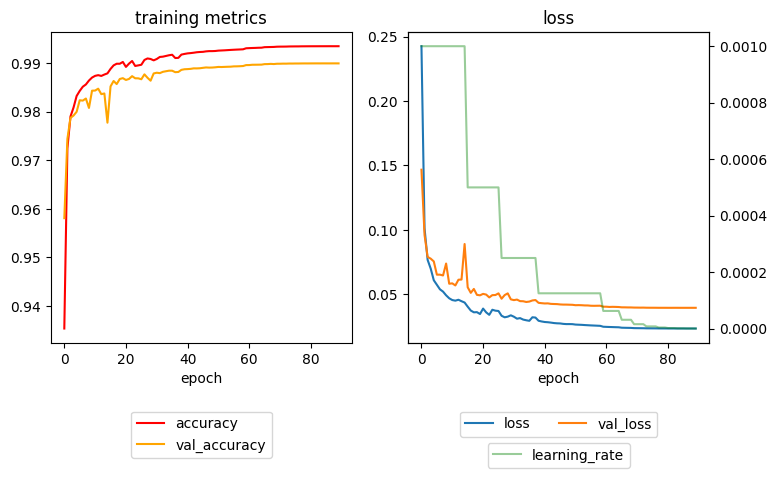

In [18]:
log = pd.read_csv(log_path)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20*cm, 15*cm))

ax1.plot(log['epoch'], log['accuracy'], label='accuracy', color='red')
ax1.plot(log['epoch'], log['val_accuracy'], label='val_accuracy', color='orange')
ax1.set_title('training metrics')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)  # Legend below the plot

ax2.plot(log['epoch'], log['loss'], label='loss')
ax2.plot(log['epoch'], log['val_loss'], label='val_loss')
# plot learning rate with different scale, show on right side
ax2b = ax2.twinx()
ax2b.plot(log['epoch'], log['learning_rate'], label='learning_rate', color='green', alpha=.4)
ax2.set_title('loss')
ax2.set_xlabel('epoch')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)  # Legend below the plot
ax2b.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)  # Legend below the plot

fig.tight_layout(rect=[0, 0.1, 1, 1])

plt.savefig(f'{checkpoint_path}/metrics_loss.svg')
plt.show()

In [19]:
# evaluate model on test data
test_loss = autoencoder.evaluate(test_gen, verbose=2)

print(f'Test loss: {test_loss}')

797/797 - 14s - 17ms/step - accuracy: 0.9502 - loss: 0.2860


Test loss: [0.2859698235988617, 0.9501954913139343]


In [ ]:
# load from .keras
autoencoder_file = load_model(f'{checkpoint_path}/autoencoder.keras')
test_loss = autoencoder_file.evaluate(test_gen, verbose=1)

print(f'Test loss: {test_loss}')

In [21]:
# load from weights
encoder_w, decoder_w, autoencoder_w = build_autoencoder(
    vocab_size=vocab_size,        # Example vocab size
    fixed_length=fixed_length,      # Example fixed length
    latent_dim=48,        # Latent space dimension
    hidden_dim=128,       # Number of neurons in hidden layers
    recurrent_layers=3     # Number of LSTM layers in encoder and decoder
)

encoder_w.load_weights(f'{checkpoint_path}/encoder.weights.h5')
decoder_w.load_weights(f'{checkpoint_path}/decoder.weights.h5')
autoencoder_w.load_weights(f'{checkpoint_path}/autoencoder.weights.h5')

test_loss = autoencoder_w.evaluate(test_gen, verbose=1)

print(f'Test loss: {test_loss}')

/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



  1/797 ━━━━━━━━━━━━━━━━━━━━ 19:45 1s/step - accuracy: 0.9406 - loss: 0.3296


  5/797 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9448 - loss: 0.3126


  8/797 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9455 - loss: 0.3091


 11/797 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9461 - loss: 0.3067


 14/797 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9467 - loss: 0.3041


 17/797 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9471 - loss: 0.3024


 20/797 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9473 - loss: 0.3022


 23/797 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9474 - loss: 0.3020


 26/797 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9475 - loss: 0.3019


 28/797 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.9476 - loss: 0.3016


 32/797 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9478 - loss: 0.3005


 35/797 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9479 - loss: 0.2999


 38/797 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9480 - loss: 0.2993


 41/797 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9481 - loss: 0.2988


 44/797 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9482 - loss: 0.2984


 47/797 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9483 - loss: 0.2979


 50/797 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9484 - loss: 0.2974


 54/797 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9485 - loss: 0.2969


 58/797 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9485 - loss: 0.2963


 61/797 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9486 - loss: 0.2959


 64/797 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9487 - loss: 0.2954


 67/797 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9487 - loss: 0.2950


 70/797 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9488 - loss: 0.2946


 73/797 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9489 - loss: 0.2942


 77/797 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9489 - loss: 0.2938


 81/797 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9490 - loss: 0.2933


 84/797 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9490 - loss: 0.2931


 88/797 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9491 - loss: 0.2927


 92/797 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9491 - loss: 0.2923


 95/797 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9492 - loss: 0.2921


 99/797 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9492 - loss: 0.2918


102/797 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9493 - loss: 0.2915


106/797 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9493 - loss: 0.2913


110/797 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9493 - loss: 0.2911


114/797 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9494 - loss: 0.2909


118/797 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9494 - loss: 0.2907


121/797 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9494 - loss: 0.2906


125/797 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9494 - loss: 0.2904


129/797 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9495 - loss: 0.2902


133/797 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9495 - loss: 0.2901


136/797 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9495 - loss: 0.2900


139/797 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9495 - loss: 0.2899


142/797 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9495 - loss: 0.2898


145/797 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9495 - loss: 0.2897


149/797 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9496 - loss: 0.2896


153/797 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9496 - loss: 0.2896


157/797 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9496 - loss: 0.2895


161/797 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9496 - loss: 0.2894


165/797 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9496 - loss: 0.2894


169/797 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9496 - loss: 0.2893


173/797 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9496 - loss: 0.2892


176/797 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9496 - loss: 0.2892


180/797 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9496 - loss: 0.2892


184/797 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9496 - loss: 0.2891


187/797 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9497 - loss: 0.2891


189/797 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9497 - loss: 0.2891


192/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2891


194/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2890


196/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2890


198/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2890


201/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2889


204/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2889


207/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2889


210/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2888


213/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2888


216/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2887


219/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2887


223/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2887


226/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2886


229/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2886


232/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2885


235/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9497 - loss: 0.2885


238/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9498 - loss: 0.2885


241/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9498 - loss: 0.2885


245/797 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9498 - loss: 0.2884


248/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2884 


251/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2884


254/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2883


257/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2883


260/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2883


263/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2882


266/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2882


270/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2881


273/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2881


276/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2881


279/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2881


282/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2880


285/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2880


288/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2880


292/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2879


294/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2879


297/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2879


300/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9498 - loss: 0.2879


303/797 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9499 - loss: 0.2878


306/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2878


308/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2878


312/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2878


316/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2877


320/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2877


324/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2877


328/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2876


331/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2876


334/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2876


337/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2876


340/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2876


343/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2875


346/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2875


350/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2875


353/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2875


356/797 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9499 - loss: 0.2875


359/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2875


362/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2874


365/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2874


369/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2874


373/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2874


376/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2874


378/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2874


381/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2874


384/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2873


387/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2873


391/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2873


394/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2873


397/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2873


400/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2873


403/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2873


406/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2873


409/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2873


412/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2873


415/797 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9499 - loss: 0.2873


419/797 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9499 - loss: 0.2872


423/797 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9499 - loss: 0.2872


427/797 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9499 - loss: 0.2872


431/797 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9499 - loss: 0.2872


434/797 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9499 - loss: 0.2872


436/797 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9499 - loss: 0.2872


438/797 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9499 - loss: 0.2872


441/797 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9499 - loss: 0.2872


444/797 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9499 - loss: 0.2872


447/797 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9499 - loss: 0.2872


449/797 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9499 - loss: 0.2872


452/797 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9499 - loss: 0.2872


454/797 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9499 - loss: 0.2872


457/797 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9499 - loss: 0.2872


460/797 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9499 - loss: 0.2872


463/797 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9499 - loss: 0.2872


466/797 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9499 - loss: 0.2872


469/797 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9499 - loss: 0.2872


471/797 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9499 - loss: 0.2872


474/797 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9499 - loss: 0.2872


477/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


480/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


484/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


488/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


491/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


494/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


497/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


500/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


503/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


505/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


508/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


511/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


514/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


517/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


520/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


523/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


526/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


528/797 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9499 - loss: 0.2872


531/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9499 - loss: 0.2872


534/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9499 - loss: 0.2872


537/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9499 - loss: 0.2872


540/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9499 - loss: 0.2872


543/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9499 - loss: 0.2872


547/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9500 - loss: 0.2872


549/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9500 - loss: 0.2872


552/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9500 - loss: 0.2872


556/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9500 - loss: 0.2872


560/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9500 - loss: 0.2872


563/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9500 - loss: 0.2872


566/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9500 - loss: 0.2872


570/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9500 - loss: 0.2871


574/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9500 - loss: 0.2871


578/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9500 - loss: 0.2871


581/797 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9500 - loss: 0.2871


584/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


586/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


589/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


592/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


595/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


599/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


602/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


606/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


609/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


611/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


613/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


616/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


619/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


622/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


625/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


629/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


631/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


634/797 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9500 - loss: 0.2871


637/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


639/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


642/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


645/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


648/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


650/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


653/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


656/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


659/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


661/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


664/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


667/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


671/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


674/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


677/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


680/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


683/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


685/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2871


689/797 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9500 - loss: 0.2870


692/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


695/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


698/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


701/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


704/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


706/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


709/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


712/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


716/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


719/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


722/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


725/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


728/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


731/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


734/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


737/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


741/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


744/797 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9500 - loss: 0.2870


748/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2870


752/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2870


755/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2870


759/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2870


762/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2870


765/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2870


768/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2869


772/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2869


775/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2869


778/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2869


781/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2869


784/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2869


787/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2869


790/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2869


793/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2869


797/797 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9500 - loss: 0.2869


797/797 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9500 - loss: 0.2869


Test loss: [0.28596031665802, 0.9501956701278687]


In [22]:
# test out encoder and decoder separately from file
encoder_file = load_model(f'{checkpoint_path}/encoder.keras')
decoder_file = load_model(f'{checkpoint_path}/decoder.keras')

# select a random sample from the test data
sample_idx = np.random.randint(0, len(test_gen))
sample = test_gen[sample_idx][0]

# encode the sample
encoded_sample = encoder_file.predict(sample)
print(f'{encoded_sample.shape=}')
print(f'{encoded_sample[0]=}')

# decode the sample
decoded_sample = decoder_file.predict(encoded_sample)
print(f'{decoded_sample.shape=}')
print(f'{decoded_sample[0]=}')

# convert the sample to strings
sample_str = vectorized_to_string(sample, idx_to_char)
decoded_sample_str = output_to_string(decoded_sample, idx_to_char)

print(f'{sample_str[0]=}')
print(f'{decoded_sample_str[0]=}')


 1/16 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step


11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


encoded_sample.shape=(512, 48)
encoded_sample[0]=array([ 0.       ,  0.       ,  0.       ,  0.       ,  7.680687 ,
        0.       ,  0.       ,  0.       ,  0.       ,  3.7973955,
        0.       ,  0.       ,  0.       ,  0.       ,  7.837739 ,
        3.7491224,  0.       ,  0.       ,  2.8936148,  0.       ,
        0.       ,  8.983229 ,  8.017273 ,  0.       ,  0.       ,
        8.25718  , 12.638321 ,  0.       ,  1.3277317,  0.       ,
        1.1121866,  0.       ,  1.2404106,  0.       ,  6.8298125,
        0.       ,  0.       ,  3.3167045,  0.       ,  0.       ,
        0.       ,  0.       ,  1.9724996,  0.       ,  0.       ,
        0.       ,  0.       ,  3.9322252], dtype=float32)



 1/16 ━━━━━━━━━━━━━━━━━━━━ 7s 531ms/step


 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


decoded_sample.shape=(512, 50, 40)
decoded_sample[0]=array([[6.1004893e-22, 1.3852666e-24, 1.0000000e+00, ..., 2.0589837e-25,
        2.2221006e-25, 1.2650836e-22],
       [1.2911901e-10, 7.6953342e-24, 2.5048843e-09, ..., 4.4754257e-12,
        1.0127045e-19, 2.5479431e-13],
       [2.2066397e-20, 1.3632401e-22, 1.4214009e-22, ..., 3.4766419e-23,
        2.7172838e-17, 5.0129164e-24],
       ...,
       [1.0000000e+00, 4.9515132e-30, 3.5550011e-32, ..., 1.6560259e-31,
        4.9005521e-30, 6.4700099e-27],
       [1.0000000e+00, 8.0811238e-30, 4.9866522e-32, ..., 7.0108781e-32,
        3.4869895e-30, 6.6990369e-27],
       [1.0000000e+00, 1.1469043e-29, 1.1954966e-31, ..., 1.2801995e-32,
        4.2158467e-30, 9.6551914e-27]], dtype=float32)
sample_str[0]='/dev/kmem'
decoded_sample_str[0]='/dev/kmem'
